In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
from tqdm.auto import tqdm

from EinsumNetwork import EinsumNetwork, Graph
from utils.dataset import ObjectCooccurrenceCOCODataset

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
dataset_train = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-train.csv")
dataset_valid = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-valid.csv")

batch_size = 8196
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size,
    True,
    drop_last=True,
    num_workers=8,
    pin_memory=device == "cuda",
)
dataloader_train2 = torch.utils.data.DataLoader(
    dataset_train, batch_size, num_workers=8, pin_memory=device == "cuda"
)
dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size, num_workers=8, pin_memory=device == "cuda"
)

In [4]:
depth = 2
num_repetitions = 5
num_input_distributions = 1
num_sums = 1

max_num_epochs = 500
online_em_frequency = 1
online_em_stepsize = 1e-4
if dataloader_train.drop_last:
    online_em_stepsize = 1 / len(dataloader_train)

EinsumNetwork(
  (einet_layers): ModuleList(
    (0): FactorizedLeafLayer(
      (ef_array): CategoricalArray()
    )
    (1-2): 2 x EinsumLayer()
    (3): EinsumMixingLayer()
  )
)
Model size:	11,620


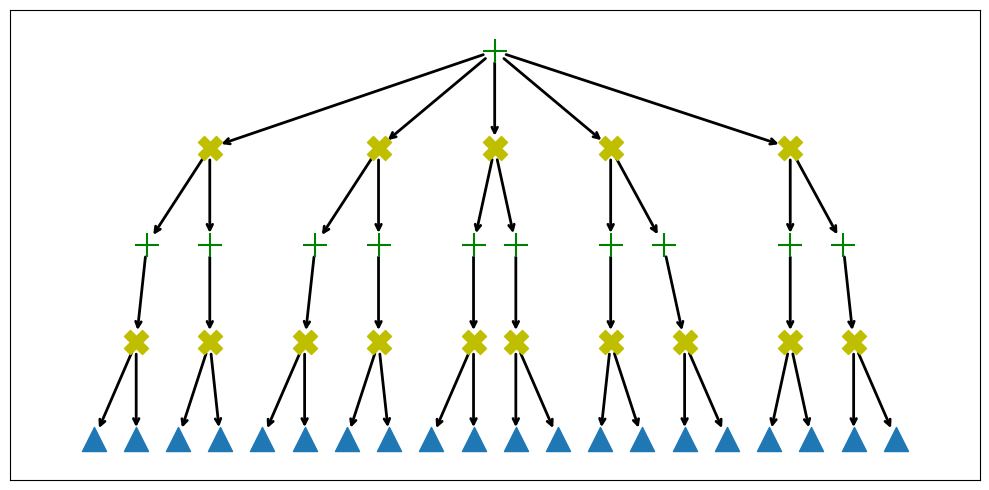

In [5]:
RG = Graph.random_binary_trees(
    num_var=dataset_train.features.shape[1],
    depth=depth,
    num_repetitions=num_repetitions,
)

args = EinsumNetwork.Args(
    num_classes=1,
    num_input_distributions=num_input_distributions,
    exponential_family=EinsumNetwork.CategoricalArray,
    exponential_family_args={"K": 29},
    num_sums=num_sums,
    num_var=dataset_train.features.shape[1],
    online_em_frequency=online_em_frequency,
    online_em_stepsize=online_em_stepsize,
)

einet = EinsumNetwork.EinsumNetwork(RG, args)
einet.initialize()
einet.to(device)
print(einet)
print("Model size:\t{:,}".format(sum(p.numel() for p in einet.parameters())))

distributions = Graph.get_leaves(RG)
products = Graph.get_products(RG)
sums = Graph.get_sums(RG)

fig = plt.figure(figsize=(10, 5))
layout = nx.nx_agraph.graphviz_layout(RG, prog="dot")
nx.draw_networkx_nodes(RG, layout, distributions, node_shape="^")
nx.draw_networkx_nodes(RG, layout, products, node_shape="X", node_color="y")
nx.draw_networkx_nodes(RG, layout, sums, node_shape="+", node_color="g")
nx.draw_networkx_edges(RG, layout, arrowstyle="->", arrowsize=10, width=2)
fig.tight_layout()
fig.savefig("outputs/einet_random_binary_tree.pdf")

In [8]:
for name, param in einet.named_parameters():
    print(name, param.size())

einet_layers.0.ef_array.params torch.Size([80, 1, 5, 29])
einet_layers.1.params torch.Size([1, 1, 1, 10])
einet_layers.2.params torch.Size([1, 1, 1, 5])
einet_layers.3.params torch.Size([1, 1, 5])


In [7]:
for epoch_count in (pbar := tqdm(range(1, max_num_epochs + 1), unit="epoch")):
    # evaluate
    train_ll = 0
    valid_ll = 0

    for inputs in dataloader_train:
        inputs = inputs.to(device)
        outputs = einet.forward(inputs)

        ll_sample = EinsumNetwork.log_likelihoods(outputs)
        log_likelihood = ll_sample.sum()

        objective = log_likelihood
        objective.backward()
        einet.em_process_batch()

    with torch.inference_mode():
        for inputs in dataloader_train2:
            inputs = inputs.to(device)
            outputs = einet.forward(inputs)

            ll_sample = EinsumNetwork.log_likelihoods(outputs)
            log_likelihood = ll_sample.sum()

            train_ll = train_ll + log_likelihood.item()

        for inputs in dataloader_valid:
            inputs = inputs.to(device)
            outputs = einet.forward(inputs)

            ll_sample = EinsumNetwork.log_likelihoods(outputs)
            log_likelihood = ll_sample.sum()

            valid_ll = valid_ll + log_likelihood.item()

    pbar.set_postfix_str(
        "Train NLL {:.4f}\tValid NLL {:.4f}".format(
            -train_ll / len(dataset_train),
            -valid_ll / len(dataset_valid),
        )
    )

  0%|          | 0/500 [00:00<?, ?epoch/s]